# Basic Climate Analysis – Western Australia

**Complete workflow: seasonal anomalies + exports for GIS**

**NARCliM2.0 tasmax analysis** (2015, SSP1-2.6) over Western Australia:

| Analysis | Output |
|----------|--------|
| Seasonal means (DJF/MAM/JJA/SON) | 4 maps + NetCDF export |
| Temperature anomalies vs annual mean | Color-coded anomaly maps |
| Perth point time series | NetCDF for local analysis |

**Key challenge**: Correctly handle rotated WRF grid for spatial analysis.

<a id="top"></a>
## Notebook structure

- [Overview](#Overview)
- [Imports](#Imports)
- [Load NARCliM2.0 data](#Load-NARCliM2.0-data)
- [Subset Western Australia](#Subset-Western-Australia)
- [Mapping Approach](#Mapping-Approach)
- [First 3 months DJF](#First-3-months-DJF)
- [Seasonal climatology and anomalies](#Seasonal-climatology-and-anomalies)
- [Regrid for GIS export](#Regrid-for-GIS-export)
- [Export products](#Export-products)
- [Interpretation](#Interpretation)
- [Next steps](#Next-steps)


## Overview

**Research question**: How does maximum temperature (`tasmax`) vary seasonally across Western Australia in 2015?

**5-step workflow**:
1. Load NARCliM2.0 from NCI THREDDS
2. Subset WA using 2D lat/lon mask (rotated grid challenge)
3. Seasonal aggregation (DJF/MAM/JJA/SON)
4. Compute anomalies vs annual mean
5. Regrid + export for GIS/stakeholder use


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Imports

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')  # Hide all warnings

import xesmf as xe
import xarray as xr
import numpy as np
import rioxarray
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from climate_utils import kelvin_to_celsius
from pathlib import Path

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Load NARCliM2.0 data

In [2]:
url = (
    "https://dapds00.nci.org.au/thredds/dodsC/zz63/NARCliM2-0/output-CMIP6/DD/AUS-18/NSW-Government/ACCESS-ESM1-5/ssp126/r6i1p1f1/NARCliM2-0-WRF412R3/v1-r1/mon/tasmax/latest/tasmax_AUS-18_ACCESS-ESM1-5_ssp126_r6i1p1f1_NSW-Government_NARCliM2-0-WRF412R3_v1-r1_mon_201501-201512.nc"
)

ds = xr.open_dataset(url)

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Subset Western Australia
The NARCliM2.0 dataset is stored on a rotated model grid.
As a result, standard coordinate selection methods (e.g. .sel(lon=…, lat=…)) are not appropriate.

Instead, Western Australia is extracted by:

using the 2-D latitude and longitude fields (lat, lon),
defining a geographic bounding box for WA, and
applying a mask that keeps only grid cells whose real-world coordinates fall inside this region.
This ensures that all subsequent calculations represent the correct geographic area.

In [3]:
# Western Australia bounding box (degrees)
central_lat = -24.5
central_lon = 121.0
buffer = 10.0

study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

print(f"Study area: lon {study_area_lon[0]:.1f}° to {study_area_lon[1]:.1f}°E")
print(f"           lat {study_area_lat[0]:.1f}° to {study_area_lat[1]:.1f}°S")


Study area: lon 111.0° to 131.0°E
           lat -34.5° to -14.5°S


In [4]:
da = ds["tasmax"]

# --- WA bounding box ---
lon_min, lon_max = 112, 129
lat_min, lat_max = -36, -13

# --- real coordinates (2-D) ---
lat2d = ds["lat"]
lon2d = ds["lon"]

# --- normalise longitude to 0–360 ---
lon2d_360 = (lon2d + 360) % 360

# --- build mask ---
wa_mask = (
    (lon2d_360 >= lon_min) & (lon2d_360 <= lon_max) &
    (lat2d >= lat_min) & (lat2d <= lat_max)
)

# --- apply mask ---
tasmax_wa = da.where(wa_mask)

print("Valid cells:", int(wa_mask.sum()))


Valid cells: 11515


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Mapping Approach

Spatial visualisations are produced using **Cartopy** with the `PlateCarree` projection.

Because the data are defined on a rotated grid, maps are generated using:

- `pcolormesh(lon, lat, data)`  
- with an explicit `transform=ccrs.PlateCarree()` argument  

This guarantees that values are plotted at their true geographic locations and prevents the empty or misplaced maps that occur when plotting rotated-grid data with default routines.


In [5]:
tasmax_wa = kelvin_to_celsius(tasmax_wa)

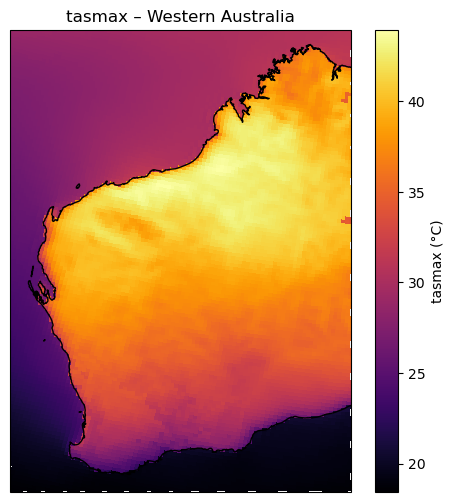

In [6]:
# --- pick one time slice to test ---
da_plot = tasmax_wa.isel(time=0)

# real coordinates
lat2d = ds["lat"]
lon2d = ds["lon"]

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# plot using real lat/lon
pcm = ax.pcolormesh(
    lon2d, lat2d, da_plot,
    transform=ccrs.PlateCarree(),
    shading="auto",
    cmap="inferno"
)

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

# focus on WA
ax.set_extent([112, 129, -36, -13], crs=ccrs.PlateCarree())

plt.colorbar(pcm, ax=ax, label="tasmax (°C)")
plt.title("tasmax – Western Australia")
plt.show()


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## First 3 months DJF


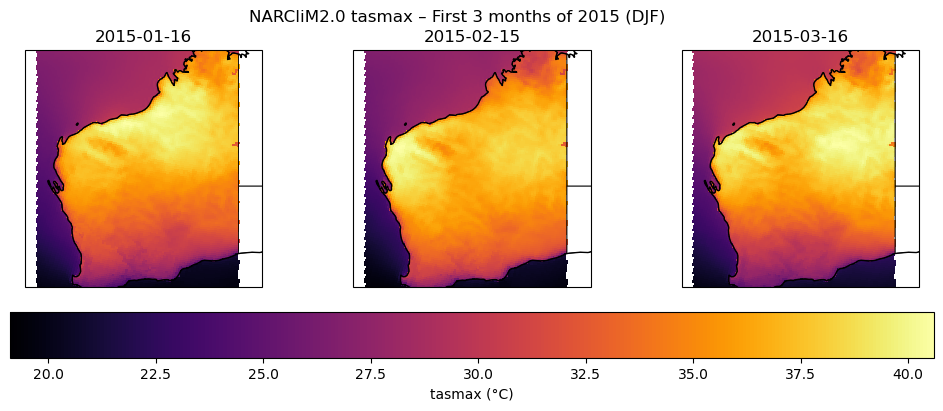

In [7]:
# Plot first 3 months (DJF summer) — CORRECT WAY

time_step = slice(0, 3)

lat2d = ds["lat"]
lon2d = ds["lon"]

fig, axes = plt.subplots(
    1, 3, figsize=(12,4),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

for i, ax in enumerate(axes):
    da_plot = tasmax_wa.isel(time=i)

    pcm = ax.pcolormesh(
        lon2d, lat2d, da_plot,
        transform=ccrs.PlateCarree(),
        shading="auto",
        cmap="inferno"
    )

    ax.set_extent(
        [study_area_lon[0], study_area_lon[1],
         study_area_lat[0], study_area_lat[1]],
        crs=ccrs.PlateCarree()
    )

    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.set_title(str(tasmax_wa.time.values[i])[:10])

plt.colorbar(pcm, ax=axes, orientation="horizontal",
             pad=0.08, label="tasmax (°C)")

plt.suptitle("NARCliM2.0 tasmax – First 3 months of 2015 (DJF)")
plt.show()


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Seasonal climatology and anomalies

To examine seasonal behaviour, the following quantities are computed:

- **Seasonal mean temperature**:  
  the average `tasmax` for each climatological season (DJF, MAM, JJA, SON).

- **Annual mean temperature**:  
  the average across all months of 2015.

- **Seasonal anomaly**:  
  the difference between each seasonal mean and the annual mean.

These anomalies highlight how each season departs from typical annual conditions and provide a clear view of seasonal contrasts across Western Australia.


In [8]:
# Calculate seasonal means (DJF, MAM, JJA, SON)
seasonal_tasmax = tasmax_wa.groupby("time.season").mean("time")

# Calculate anomalies relative to annual mean
annual_mean = tasmax_wa.mean("time")
seasonal_anomaly = seasonal_tasmax - annual_mean

print("Seasons calculated:", list(seasonal_anomaly.season.values))


Seasons calculated: ['DJF', 'JJA', 'MAM', 'SON']


## Plot Seasonal Anomalities

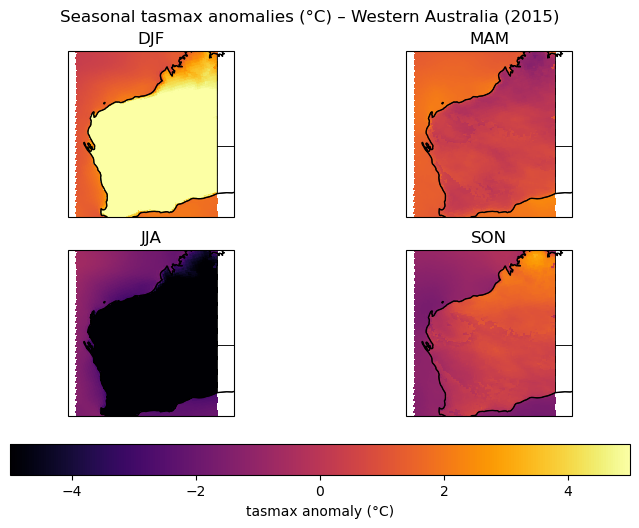

In [9]:
from matplotlib.colors import TwoSlopeNorm

# --- Plot all seasons (CORRECT for WRF / rotated grid) ---

lat2d = ds["lat"]
lon2d = ds["lon"]

fig, axes = plt.subplots(
    2, 2, figsize=(8, 6),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

axes = axes.flatten()
seasons = ["DJF", "MAM", "JJA", "SON"]

vmin = -5
vmax = 5
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

for ax, s in zip(axes, seasons):

    da_s = seasonal_anomaly.sel(season=s)

    pcm = ax.pcolormesh(
        lon2d,
        lat2d,
        da_s,
        transform=ccrs.PlateCarree(),
        shading="auto",
        cmap="inferno",
        norm=norm
    )

    ax.set_extent(
        [
            study_area_lon[0], study_area_lon[1],
            study_area_lat[0], study_area_lat[1]
        ],
        crs=ccrs.PlateCarree()
    )
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.set_title(s)

# Shared colorbar (degC)
cbar = plt.colorbar(
    pcm,
    ax=axes,
    orientation="horizontal",
    pad=0.06,
    label="tasmax anomaly (°C)"
)

plt.suptitle(
    "Seasonal tasmax anomalies (°C) – Western Australia (2015)",
    y=0.95
)

plt.show()


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Regrid for GIS export

While analysis and mapping are performed on the native WRF grid, spatial exports (e.g. for GIS or web mapping) require data on a **regular lat/lon grid**.

Seasonal anomalies are therefore regridded using bilinear interpolation onto a uniform grid covering Western Australia.  
This step enables:

- simple plotting with standard tools,  
- compatibility with GIS software, and  
- consistent export to common spatial formats.

The regridded product forms the basis for all exported spatial layers.


In [10]:
# -------------------------------------------------
# Regrid seasonal anomalies to lat/lon grid
# -------------------------------------------------

# target regular grid over Western Australia
lon_new = np.arange(112, 129.05, 0.05)
lat_new = np.arange(-36, -12.95, 0.05)

ds_out = xr.Dataset(
    {
        "lat": (["lat"], lat_new),
        "lon": (["lon"], lon_new),
    }
)

# build regridder (WRF → regular grid)
regridder = xe.Regridder(
    seasonal_anomaly,
    ds_out,
    method="bilinear",
    periodic=False
)


seasonal_anom_ll = regridder(seasonal_anomaly)
print(seasonal_anom_ll)


<xarray.DataArray (season: 4, lat: 461, lon: 342)> Size: 3MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,  0.65710664, ...,         nan,
                 nan,         nan],
        [        nan,         nan,  0.66908866, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
  

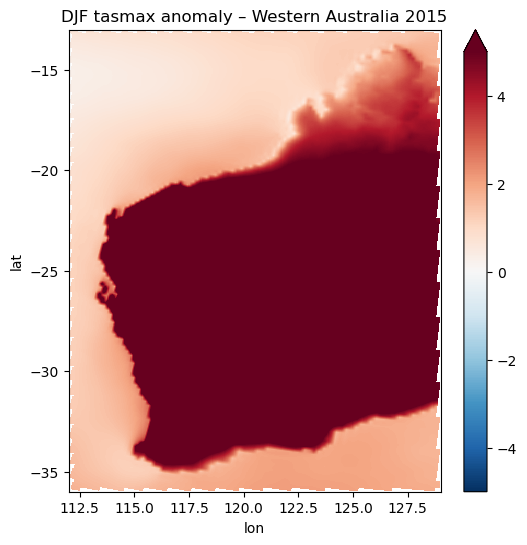

In [11]:
seasonal_anom_ll.sel(season="DJF").plot(
    cmap="RdBu_r",
    vmin=-5, vmax=5,
    figsize=(6,6)
)
plt.xlim(112, 129)
plt.ylim(-36, -13)
plt.title("DJF tasmax anomaly – Western Australia 2015")
plt.show()


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Export products

Two types of outputs are generated from the analysis:

1. **Seasonal anomaly fields**  
   Regridded seasonal anomalies are saved in NetCDF format, preserving:
   - latitude and longitude coordinates,  
   - seasonal dimension, and  
   - full metadata.

   These files can be opened directly in GIS platforms (QGIS, ArcGIS), scientific viewers (Panoply), or used in downstream modelling workflows.

2. **Perth temperature time series**  
   A representative point time series is extracted for the Perth region by:
   - computing distances on the 2-D latitude/longitude grid, and  
   - selecting the grid cell closest to the target location.

   The resulting time series is exported as a NetCDF file for local-scale analysis and comparison with observations.


In [12]:
output_dir = Path("output")
output_dir.mkdir(parents=True, exist_ok=True)

In [13]:
# Export seasonal anomalies as NetCDF
anom_file = output_dir / "tasmax_anomaly_WA_2015.nc"
seasonal_anom_ll.to_netcdf(anom_file)
print(f"Exported: {anom_file}")


Exported: output/tasmax_anomaly_WA_2015.nc


In [24]:
# Export seasonal anomalies as NetCDF
seasonal_anom_ll.to_netcdf("tasmax_anomaly_WA_2015.nc")
print("Exported: tasmax_anomaly_WA_2015.nc")


Exported: tasmax_anomaly_WA_2015.nc


In [14]:
# target location: Perth
target_lon, target_lat = 116.0, -32.0

lat2d = ds["lat"]
lon2d = ds["lon"]

# squared distance
dist2 = (lat2d - target_lat)**2 + (lon2d - target_lon)**2

# closest grid point
idx = dist2.argmin(dim=("rlat", "rlon"))
rlat_idx = idx["rlat"].item()
rlon_idx = idx["rlon"].item()

perth_ts = tasmax_wa.isel(rlat=rlat_idx, rlon=rlon_idx)

perth_file = output_dir / "perth_tasmax_2015.nc"
perth_ts.to_netcdf(perth_file)
print(f"Exported: {perth_file}")


Exported: output/perth_tasmax_2015.nc


In [25]:
# target location: Perth
target_lon, target_lat = 116.0, -32.0

lat2d = ds["lat"]
lon2d = ds["lon"]

# squared distance
dist2 = (lat2d - target_lat)**2 + (lon2d - target_lon)**2

# closest grid point
idx = dist2.argmin(dim=("rlat", "rlon"))
rlat_idx = idx["rlat"].item()
rlon_idx = idx["rlon"].item()

perth_ts = tasmax_wa.isel(rlat=rlat_idx, rlon=rlon_idx)

perth_ts.to_netcdf("perth_tasmax_2015.nc")
print("Exported: perth_tasmax_2015.nc")


Exported: perth_tasmax_2015.nc


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Interpretation

The seasonal anomaly patterns reveal clear spatial and temporal contrasts in maximum temperature across Western Australia:

- **Summer (DJF)** shows the strongest positive anomalies, particularly in northern and inland regions, reflecting intense seasonal heating.  
- **Winter (JJA)** exhibits widespread negative anomalies, consistent with cooler conditions across the state.  
- **Autumn (MAM)** and **spring (SON)** represent transitional regimes, with mixed spatial patterns as the climate shifts between warm and cool seasons.

The Perth time series demonstrates a pronounced seasonal cycle, with peak temperatures in summer and minimum values in winter, aligning with the broader regional patterns observed in the spatial fields.


This notebook demonstrates a complete, spatially consistent workflow for analysing regional climate model output on a rotated grid.

Key strengths of the approach include:
- correct handling of WRF grid geometry,  
- robust seasonal anomaly computation,  
- accurate cartographic visualisation, and  
- production of reusable spatial and point-based climate products.

The methods used here provide a reliable foundation for extending the analysis to additional years, variables, or climate scenarios.


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Next steps
Change time period: Modify file_url for different years

Different variable: Replace tasmax with tasmin or pr

Different scenario: Use ssp370 instead of ssp126

Smaller region: Adjust buffer for Pilbara, Kimberley, etc.

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>